##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [34]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
# import warnings
# warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
# import LSTM_Train as LSTM
import importlib
# import LSTM
import DenseNet as Dense
# importlib.reload(LSTM)
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# pool.close()

In [39]:
def Curve(x,a,b,c):
    return (a/(b+x)**c)

def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
    return(Models)

def TTV_Split(iteration,Memory,X,y,params,X_fill):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=iteration)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=iteration)
    return(Dense.Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,
                            y_val,iteration,X_fill = X_fill,Memory=Memory),y_val)

def RunReps(Model,params,pool = None,plot=False,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    if params['T'] >0:
        RST.TimeShape(params['T'])
    y = RST.y*1.0
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
    MSE = []
    R2 =[]
    Y_fill = []
    Yval = []
    y_val= []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),
                                             range(params['K']))):
            Y_fill.append(results[0][0])
            Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
            MSE.append(metrics.mean_squared_error(Yval,y_val))
            R2.append(metrics.r2_score(Yval,y_val))
    else:
        for i in range(params['K']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            Y_fill.append(results[0][0])
            Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
            MSE.append(metrics.mean_squared_error(Yval,y_val))
            R2.append(metrics.r2_score(Yval,y_val))
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0) 
    FillVarName = FillVar.replace('f','F')
    RST.Fill(Y_fill,FillVarName) 
    
    return(MSE,R2,RST.Master['TempFill'])
#     if FullReturn == False:
#         return(MSE,R2,RST.Master['TempFill'])
# #         return(MSE,RST.Master['TempFill'],R2)
#     else:
#         return(MSE,R2)

In [40]:
FillVar = 'fch4'
FullModel = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg',
             'VPD','Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
FullModel = ['PPFD_Avg','AirTC_Avg','Sedge','VWC','Grass']
Runs,params = Dense.Params('Test',FillVar,MP=False)
print(params)

{'proc': 1, 'K': 3, 'epochs': 100, 'Y': 'fch4'}


In [41]:
Time = time.time()
Path = 'Data_Footprints_2018-06-12.csv'

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    
def RunLoop(Runs):
    for N in Runs['N'].unique():
        params['T'] = 0
        params['N']=N
        Results = RunReps(FullModel,params,pool,plot=True)
        MSE = Results[0]
        R2 = Results[1]
        Runs.loc[Runs['N']==N,'MSE']=MSE
        Runs.loc[Runs['N']==N,'R2']=R2
        print(Runs.loc[Runs['N']==N])
    return(Runs)

Runs = RunLoop(Runs)

   N        MSE        R2
0  4  86.452471 -1.376599
1  4  88.610795 -3.372810
2  4  88.199515 -0.599466
    N        MSE        R2
3  16  49.761825  0.458860
4  16  69.944018 -1.000787
5  16  66.244754 -0.180070
    N        MSE        R2
6  36  49.913740  0.462647
7  36  61.436450 -0.703549
8  36  63.003504 -0.035525
     N        MSE        R2
9   64  46.867854  0.511659
10  64  62.196082 -0.653025
11  64  64.211023 -0.017962
      N        MSE        R2
12  100  46.655984  0.504491
13  100  63.371878 -0.796974
14  100  65.266649 -0.092532


# The "Optimum" Sized Model

           MSE        R2         SD        SE
N                                            
4    87.754260 -1.782958   1.145984  0.661634
16   61.983532 -0.240666  10.744708  6.203460
36   58.117898 -0.092143   7.148082  4.126947
64   57.758320 -0.053109   9.485076  5.476211
100  58.431504 -0.128338  10.241811  5.913112


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


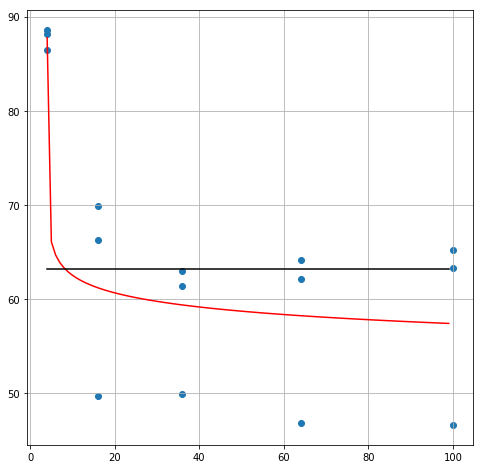

9 63.234531146908054
121.24847865104675


In [42]:

Group = Runs.groupby('N').mean()
Group['SD'] = Runs[['N','MSE']].groupby('N').std()
Group['SE'] = Runs[['N','MSE']].groupby('N').sem()

print(Group)
Min = Group.loc[Group['MSE']==Group['MSE'].min()]

fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(Runs['N'],Runs['MSE'])
popt, pcov = curve_fit(Curve, Runs['N'].values, Runs['MSE'].values)
N = np.arange(Runs['N'].min(),Runs['N'].max())
Fit = Curve(N,*popt)
ax.plot(N,Fit,color='r')
Max = (Min['MSE']+Min['SE']).values[0]
ax.plot(N,N*0+Max,color = 'black')
plt.grid()
plt.show()
try:
    params['N']=N[Fit<Max].min()
except:
    params['N']=N[-1]
    pass
print(params['N'],Max)
print(time.time()-Time)

# Feature Identification

In [45]:
Scores = Runs[['MSE','R2']].reset_index(drop=True)
Scores = (Scores.iloc[0:params['K']])*0
Scores['Level'] = len(FullModel)
Scores['Key'] = str(Scores['Level'][0])+'_0'
Scores['Model'] = '+'.join(FullModel)

Results = RunReps(FullModel,params,pool)

MSE = Results[0]
R2 = Results[1]
# mean,std = np.asanyarray(MSE).mean(),np.asanyarray(MSE).std()
# CI = std/params['K']**.5*stats.t.ppf(1-0.05, params['K']-1)
Scores['MSE']=Results[0]#MSE#mean
Scores['R2']=Results[1]#R2#.mean()

ModelRuns = Results[2]
ModelRuns = ModelRuns.to_frame()
ModelRuns['Model: '+'+'.join(FullModel)]=ModelRuns['TempFill']
ModelRuns=ModelRuns.drop('TempFill',axis=1)
print(Scores)

         MSE        R2  Level  Key                               Model
0  58.816132  0.270730      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass
1  71.619531 -1.015699      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass
2  71.250657 -0.316879      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass


In [46]:
for i in range(1,len(FullModel)):
    print('Level: ',i)
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
    Values = []
    Names = []
    for i,model in enumerate(Models):
        level = len(model)
        key = str(level)+'_'+str(i)
        Name = '+'.join(model)
        NewRow = Scores.iloc[-1].copy()
        NewRow['Model'] = 'Model: '+Name
        Results = RunReps(model,params,pool)
        MSE = Results[0]
        R2 = Results[1]
        d = {'Model':'+'.join(model),'MSE':MSE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
        score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
        Scores = Scores.append(score,ignore_index=True)
        print(Scores.loc[Scores['Key']==key])
        ModelRuns['Model: '+'+'.join(model)] = Results[2]    
    Group = Scores.groupby('Key').agg({'Model': 'first', 
                                            'Level': 'first', 
                                            'MSE': 'mean', 
                                            'R2': 'mean'})#.reset_index()#mean()  
    Group['SD'] = Scores[['Key','MSE']].groupby('Key').std()
    Group['SE'] = Scores[['Key','MSE']].groupby('Key').sem()
    Min = Group.loc[Group['Level']==level]
    Best = Min.loc[Min['MSE'] == Min['MSE'].min(),'Model'].values
    print(Best)
    

Level:  1


C:\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


   Key  Level         MSE     Model          R2
3  1_0      1  156.903099  PPFD_Avg  -24.267957
4  1_0      1  117.461079  PPFD_Avg  -56.068982
5  1_0      1  127.915747  PPFD_Avg -171.707000
   Key  Level         MSE      Model         R2
6  1_1      1  144.494171  AirTC_Avg -17.904157
7  1_1      1  111.042951  AirTC_Avg -17.526503
8  1_1      1  125.052150  AirTC_Avg -17.714071
    Key  Level         MSE  Model        R2
9   1_2      1  131.587189  Sedge -6.929600
10  1_2      1  109.695472  Sedge -7.277758
11  1_2      1  117.477821  Sedge -6.332558
    Key  Level         MSE Model         R2
12  1_3      1  145.152068   VWC -38.794673
13  1_3      1  117.304628   VWC -20.014713
14  1_3      1  117.212661   VWC -25.933860
    Key  Level         MSE  Model         R2
15  1_4      1  150.503377  Grass -22.384490
16  1_4      1  114.574116  Grass -24.212856
17  1_4      1  116.243146  Grass -15.318489
['Sedge']
Level:  2
    Key  Level         MSE           Model        R2
18  2_0    

                                  Model  Level         MSE        R2  \
Key                                                                    
1_2                               Sedge      1  119.586828 -6.846639   
2_2                           Sedge+VWC      2   78.073872 -1.341464   
3_2                     Sedge+VWC+Grass      3   71.983148 -0.655523   
4_1           AirTC_Avg+Sedge+VWC+Grass      4   74.582143 -0.692239   
5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass      5   67.228773 -0.353949   

            SD        SE  
Key                       
1_2  11.097195  6.406969  
2_2   7.124975  4.113606  
3_2   5.547821  3.203036  
4_1   1.779221  1.027234  
5_0   7.287895  4.207668  
                                Model  Level        MSE        R2        SD  \
4  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass      5  67.228773 -0.353949  7.287895   

         SE  
4  4.207668  


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


   N        MSE        R2
0  4  86.455403 -1.376928
1  4  88.603614 -3.370912
2  4  88.246206 -0.597332
    N        MSE        R2
3  16  49.767541  0.459424
4  16  69.923231 -0.998003
5  16  66.244239 -0.180005
    N        MSE        R2
6  36  49.865133  0.463606
7  36  61.888802 -0.734880
8  36  63.026459 -0.035682
     N        MSE        R2
9   64  46.857750  0.511789
10  64  62.180826 -0.650891
11  64  64.240284 -0.019291
      N        MSE        R2
12  100  46.554862  0.502895
13  100  63.342358 -0.798377
14  100  65.267063 -0.092265
           MSE        R2         SD        SE
N                                            
4    87.754260 -1.782958   1.145984  0.661634
16   61.983532 -0.240666  10.744708  6.203460
36   58.117898 -0.092143   7.148082  4.126947
64   57.758320 -0.053109   9.485076  5.476211
100  58.431504 -0.128338  10.241811  5.913112
9


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power


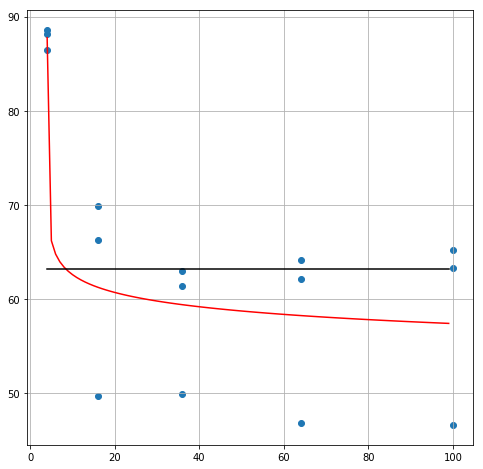

9


In [47]:
Group = Scores.groupby('Key').agg({'Model': 'first', 
                                        'Level': 'first', 
                                        'MSE': 'mean', 
                                        'R2': 'mean'})#.reset_index()#mean()  
Group['SD'] = Scores[['Key','MSE']].groupby('Key').std()
Group['SE'] = Scores[['Key','MSE']].groupby('Key').sem()
Min = Group.loc[Group['Level']==level]

Levels = Group.groupby('Level').min()
Sub=Group[Group['MSE'].isin(Levels['MSE'].values)]
print(Sub)
Sub.sort_values('Level',inplace=True)
Sub = Sub.loc[Sub['Level']>=1]
Sub.reset_index(inplace=True,drop=True)
Min = Sub.loc[Sub['MSE']==Sub['MSE'].min()]
Parsimony = (Sub.loc[Sub['MSE']<(Min['MSE'].values+Min['SE'].values)[0]])
Parsimony = Parsimony.loc[Parsimony['Level']==Parsimony['Level'].min()]
print(Parsimony)
Best = Parsimony['Model'].values

def Curve(x,a,b,c):
    return (a/(b+x)**c)

N = Runs['N']
NRuns = Runs*0
NRuns['N']=N

model = Best[0].split('+')
NRuns = RunLoop(NRuns)
Group = Runs.groupby('N').mean()
Group['SD'] = Runs[['N','MSE']].groupby('N').std()
Group['SE'] = Runs[['N','MSE']].groupby('N').sem()

print(Group)
Min = Group.loc[Group['MSE']==Group['MSE'].min()]

fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(Runs['N'],Runs['MSE'])
popt, pcov = curve_fit(Curve, NRuns['N'].values, NRuns['MSE'].values)

N = np.arange(NRuns['N'].min(),NRuns['N'].max())
Fit = Curve(N,*popt)
ax.plot(N,Fit,color='r')
Max = (Min['MSE']+Min['SE']).values[0]
ax.plot(N,N*0+Max,color = 'black')
try:
    params['N']=N[Fit<Max].min()
except:
    params['N']=N[-1]
    pass
print(params['N'])
plt.grid()
plt.show()
print(params['N'])

In [49]:
level = 0#len(Best)
print(Best)
key = '0_'+str(params['N'])
Name = '+'.join(Best)
NewRow = Scores.iloc[-1].copy()
NewRow['Model'] = 'BestModel: '+Name
Results = RunReps(model,params,pool)
MSE = Results[0]
# for mse in MSE:
#     Names.append(Name)
#     Values.append(mse)
# mean,std = MSE.mean(),MSE.std()
# CI = std/params['K']**.5*stats.t.ppf(1-0.05, params['K']-1)
R2 = Results[1]
d = {'Model':'+'.join(model),'MSE':MSE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
Scores = Scores.append(score,ignore_index=True)
Scores = Scores.append(score,ignore_index=True)
ModelRuns['BestModel: '+'+'.join(model)] = Results[2] 
print(params['N'])

['PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass']
9


C:\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [20]:
Scores.to_csv('GapFillingSummary'+FillVar+'.csv')
ModelRuns.to_csv('GapFilled'+FillVar+'.csv')

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

print(time.time()-Time)

504.90875220298767
